In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import requests
import os
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import brentq
import scipy.stats as si
from scipy.stats import norm
import matplotlib.patches as patches
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.patches as patches
API_KEY = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
us_holidays = holidays.US(years=2024)
dst_start = pd.to_datetime('2024-03-10')
dst_end = pd.to_datetime('2024-11-03')
fila =6 # Determina el ancho de la caja en la que buscaremos el máx y el mín.
# no confundir fila que determina la caja del IB con row que determina el núm. de índice cuando la caja es rota.

In [2]:
def get_time_based_on_dst(fecha):
    if dst_start <= fecha <= dst_end:
        return pd.to_datetime('13:30:00').time()
    else:
        return pd.to_datetime('14:30:00').time()

def get_stock_price(date, expiration_day):
    url = f"https://api.polygon.io/v2/aggs/ticker/AAPL/range/1/day/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    #https://api.polygon.io/v2/aggs/ticker/O:AAPL240802P00180000/range/1/day/2024-07-22/2024-08-02?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
    print(url)  # For debugging purposes
    response = requests.get(url)

    if response.status_code == 200:
        try:
            data = response.json()
            if 'results' in data:
                return [(result['t'], result['c']) for result in data['results']]  # 'c' is the close price
            else:
                raise ValueError("Response JSON does not contain 'results' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return []

# Function to get stock data for the specified date range
def get_stock_data_for_date(date, expiration):
    option_data = get_stock_price(date, expiration)
    if option_data:
        df = pd.DataFrame(option_data, columns=['timestamp', 'close_price'])
        df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['close_price'] = round(df['close_price'], 2)
        df = df.reset_index(drop=True)
        return df
    else:
        return pd.DataFrame(columns=['timestamp', 'close_price', 'fecha'])


In [3]:
date =          '2024-05-16'
expiration  =   '2024-08-09'
df = get_stock_data_for_date(date, expiration)

https://api.polygon.io/v2/aggs/ticker/AAPL/range/1/day/2024-05-16/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF


In [4]:
df

,timestamp,close_price,fecha
0,1715832000000,189.84,2024-05-16 04:00:00
1,1715918400000,189.87,2024-05-17 04:00:00
2,1716177600000,191.04,2024-05-20 04:00:00
3,1716264000000,192.35,2024-05-21 04:00:00
4,1716350400000,190.90,2024-05-22 04:00:00
5,1716436800000,186.88,2024-05-23 04:00:00
6,1716523200000,189.98,2024-05-24 04:00:00
7,1716868800000,189.99,2024-05-28 04:00:00
8,1716955200000,190.29,2024-05-29 04:00:00
9,1717041600000,191.29,2024-05-30 04:00:00


In [5]:
def get_option_price(ticker, date, expiration_day, option_type):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    print(url)
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            # Ensure 'results' key is present in the JSON response
            if 'results' in data:
                results = data['results']
                df_option = pd.DataFrame(results)
                
                # Check what columns are in df_option
                #print(df_option.columns)
                
                # Rename columns if they exist
                if all(col in df_option.columns for col in ['o', 'c', 'l', 'h']):
                    df_option = df_option.rename(columns={
                        't': 'timestamp',
                        'o': 'open',
                        'c': 'close',
                        'l': 'low',
                        'h': 'high'
                    })
                    df_option['option_code'] = ticker
                    df_option['option_type'] = option_type                
                    return df_option[['timestamp', 'option_code', 'option_type', 'close']]
                else:
                    print("Expected columns are not present in the returned data.")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [20]:
# pata vendida
ticker = 'O:AAPL240802P00200000'
date = '2024-05-16'
expiration_day = '2024-08-02'
option_type ='P'
current_stock_price = int(df.iloc[0]['close_price'])
print(f'Option ticker {ticker}')
print(f'ATM strike at {date} is {current_stock_price}')
df_option_B = get_option_price(ticker, date, expiration_day, option_type)
df_option_B.rename(columns={'option_code': 'option_code_B', 'close': 'close_B', 'option_type': 'option_type_B'}, inplace=True)
df_option_B

Option ticker O:AAPL240802P00200000
ATM strike at 2024-05-16 is 189
https://api.polygon.io/v2/aggs/ticker/O:AAPL240802P00200000/range/1/day/2024-05-16/2024-08-02?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF


,timestamp,option_code_B,option_type_B,close_B
0,1718251200000,O:AAPL240802P00200000,P,2.55
1,1718337600000,O:AAPL240802P00200000,P,2.35
2,1718596800000,O:AAPL240802P00200000,P,1.85
3,1718683200000,O:AAPL240802P00200000,P,2.22
4,1718856000000,O:AAPL240802P00200000,P,2.94
5,1718942400000,O:AAPL240802P00200000,P,3.05
6,1719201600000,O:AAPL240802P00200000,P,2.90
7,1719288000000,O:AAPL240802P00200000,P,2.43
8,1719374400000,O:AAPL240802P00200000,P,1.68
9,1719460800000,O:AAPL240802P00200000,P,1.56


In [7]:
df_option = pd.merge(df_option_B, df, on='timestamp', how='left')
df_option

,timestamp,option_code_B,option_type_B,close_B,close_price,fecha
0,1718251200000,O:AAPL240802P00200000,P,2.55,214.24,2024-06-13 04:00:00
1,1718337600000,O:AAPL240802P00200000,P,2.35,212.49,2024-06-14 04:00:00
2,1718596800000,O:AAPL240802P00200000,P,1.85,216.67,2024-06-17 04:00:00
3,1718683200000,O:AAPL240802P00200000,P,2.22,214.29,2024-06-18 04:00:00
4,1718856000000,O:AAPL240802P00200000,P,2.94,209.68,2024-06-20 04:00:00
5,1718942400000,O:AAPL240802P00200000,P,3.05,207.49,2024-06-21 04:00:00
6,1719201600000,O:AAPL240802P00200000,P,2.90,208.14,2024-06-24 04:00:00
7,1719288000000,O:AAPL240802P00200000,P,2.43,209.07,2024-06-25 04:00:00
8,1719374400000,O:AAPL240802P00200000,P,1.68,213.25,2024-06-26 04:00:00
9,1719460800000,O:AAPL240802P00200000,P,1.56,214.10,2024-06-27 04:00:00


In [8]:
ticker = 'O:AAPL240809P00200000'
date = '2024-06-13'
expiration_day = '2024-08-09'
option_type ='P'
current_stock_price = int(df.iloc[0]['close_price'])
print(f'Option ticker {ticker}')
print(f'ATM strike at {date} is {current_stock_price}')
df_option_A = get_option_price(ticker, date, expiration_day, option_type)
df_option_A.rename(columns={'option_code': 'option_code_A', 'close': 'close_A', 'option_type': 'option_type_A'}, inplace=True)
df_option_A = df_option_A.dropna(subset=['close_A'])
df_option_A 

Option ticker O:AAPL240809P00200000
ATM strike at 2024-06-13 is 189
https://api.polygon.io/v2/aggs/ticker/O:AAPL240809P00200000/range/1/day/2024-06-13/2024-08-09?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF


,timestamp,option_code_A,option_type_A,close_A
0,1719460800000,O:AAPL240809P00200000,P,1.81
1,1719547200000,O:AAPL240809P00200000,P,2.50
2,1719806400000,O:AAPL240809P00200000,P,1.47
3,1719892800000,O:AAPL240809P00200000,P,1.03
4,1719979200000,O:AAPL240809P00200000,P,0.87
5,1720152000000,O:AAPL240809P00200000,P,0.61
6,1720411200000,O:AAPL240809P00200000,P,0.47
7,1720497600000,O:AAPL240809P00200000,P,0.43
8,1720584000000,O:AAPL240809P00200000,P,0.43
9,1720670400000,O:AAPL240809P00200000,P,0.49


In [9]:
df_option = pd.merge(df_option_A, df_option,  on='timestamp', how='left')

df_option = df_option.fillna(method='ffill')
df_option

,timestamp,option_code_A,option_type_A,close_A,option_code_B,option_type_B,close_B,close_price,fecha
0,1719460800000,O:AAPL240809P00200000,P,1.81,O:AAPL240802P00200000,P,1.56,214.10,2024-06-27 04:00:00
1,1719547200000,O:AAPL240809P00200000,P,2.50,O:AAPL240802P00200000,P,2.15,210.62,2024-06-28 04:00:00
2,1719806400000,O:AAPL240809P00200000,P,1.47,O:AAPL240802P00200000,P,1.07,216.75,2024-07-01 04:00:00
3,1719892800000,O:AAPL240809P00200000,P,1.03,O:AAPL240802P00200000,P,0.75,220.27,2024-07-02 04:00:00
4,1719979200000,O:AAPL240809P00200000,P,0.87,O:AAPL240802P00200000,P,0.65,221.55,2024-07-03 04:00:00
5,1720152000000,O:AAPL240809P00200000,P,0.61,O:AAPL240802P00200000,P,0.46,226.34,2024-07-05 04:00:00
6,1720411200000,O:AAPL240809P00200000,P,0.47,O:AAPL240802P00200000,P,0.35,227.82,2024-07-08 04:00:00
7,1720497600000,O:AAPL240809P00200000,P,0.43,O:AAPL240802P00200000,P,0.35,228.68,2024-07-09 04:00:00
8,1720584000000,O:AAPL240809P00200000,P,0.43,O:AAPL240802P00200000,P,0.35,232.98,2024-07-10 04:00:00
9,1720670400000,O:AAPL240809P00200000,P,0.49,O:AAPL240802P00200000,P,0.42,227.57,2024-07-11 04:00:00


In [18]:
coste_A = df_option['close_A'].iloc[0]
print(coste_A)
df_option['cum_return_A'] = df_option['close_A'] - coste_A 

coste_B = df_option['close_B'].iloc[0]
print(coste_B)
df_option['cum_return_B'] = coste_B - df_option['close_B']

1.81
1.56


In [11]:
df_option

,timestamp,option_code_A,option_type_A,close_A,option_code_B,option_type_B,close_B,close_price,fecha,cum_return_B,cum_return_A
0,1719460800000,O:AAPL240809P00200000,P,1.81,O:AAPL240802P00200000,P,1.56,214.10,2024-06-27 04:00:00,0.00,0.00
1,1719547200000,O:AAPL240809P00200000,P,2.50,O:AAPL240802P00200000,P,2.15,210.62,2024-06-28 04:00:00,-0.59,0.69
2,1719806400000,O:AAPL240809P00200000,P,1.47,O:AAPL240802P00200000,P,1.07,216.75,2024-07-01 04:00:00,0.49,-0.34
3,1719892800000,O:AAPL240809P00200000,P,1.03,O:AAPL240802P00200000,P,0.75,220.27,2024-07-02 04:00:00,0.81,-0.78
4,1719979200000,O:AAPL240809P00200000,P,0.87,O:AAPL240802P00200000,P,0.65,221.55,2024-07-03 04:00:00,0.91,-0.94
5,1720152000000,O:AAPL240809P00200000,P,0.61,O:AAPL240802P00200000,P,0.46,226.34,2024-07-05 04:00:00,1.10,-1.20
6,1720411200000,O:AAPL240809P00200000,P,0.47,O:AAPL240802P00200000,P,0.35,227.82,2024-07-08 04:00:00,1.21,-1.34
7,1720497600000,O:AAPL240809P00200000,P,0.43,O:AAPL240802P00200000,P,0.35,228.68,2024-07-09 04:00:00,1.21,-1.38
8,1720584000000,O:AAPL240809P00200000,P,0.43,O:AAPL240802P00200000,P,0.35,232.98,2024-07-10 04:00:00,1.21,-1.38
9,1720670400000,O:AAPL240809P00200000,P,0.49,O:AAPL240802P00200000,P,0.42,227.57,2024-07-11 04:00:00,1.14,-1.32


In [12]:
columns_to_drop = ['option_code_B', 'option_type_B', 'option_code_A', 'option_type_A']
df_option = df_option.drop(columns=columns_to_drop, errors='ignore')

In [13]:
df_option['leg_P'] = df_option['cum_return_A'] + df_option['cum_return_B']

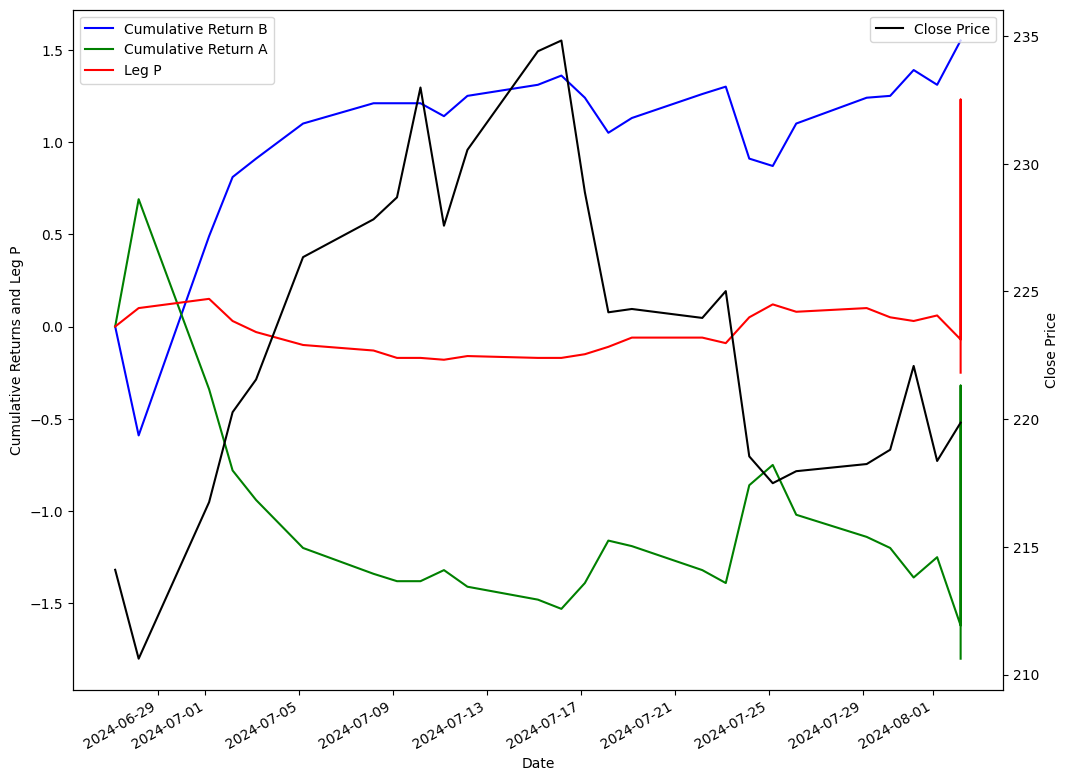

In [14]:
import matplotlib.pyplot as plt

# Assuming df is already defined and contains the relevant columns

# Create a plot with two y-axes, setting the figure size to 12x10 inches
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot cum_return_B, cum_return_A, and leg_P on the left y-axis (ax1)
ax1.plot(df_option['fecha'], df_option['cum_return_B'], label='Cumulative Return B', color='blue')
ax1.plot(df_option['fecha'], df_option['cum_return_A'], label='Cumulative Return A', color='green')
ax1.plot(df_option['fecha'], df_option['leg_P'], label='Leg P', color='red')

# Plot close_price on the right y-axis (ax2)
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
ax2.plot(df_option['fecha'], df_option['close_price'], label='Close Price', color='black')

# Set labels
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns and Leg P')
ax2.set_ylabel('Close Price', color='black')

# Set the color of the ticks and label for the right y-axis to black
ax2.tick_params(axis='y', labelcolor='black')

# Add legends to both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Optionally, format the date on the x-axis
fig.autofmt_xdate()

# Show plot
plt.show()



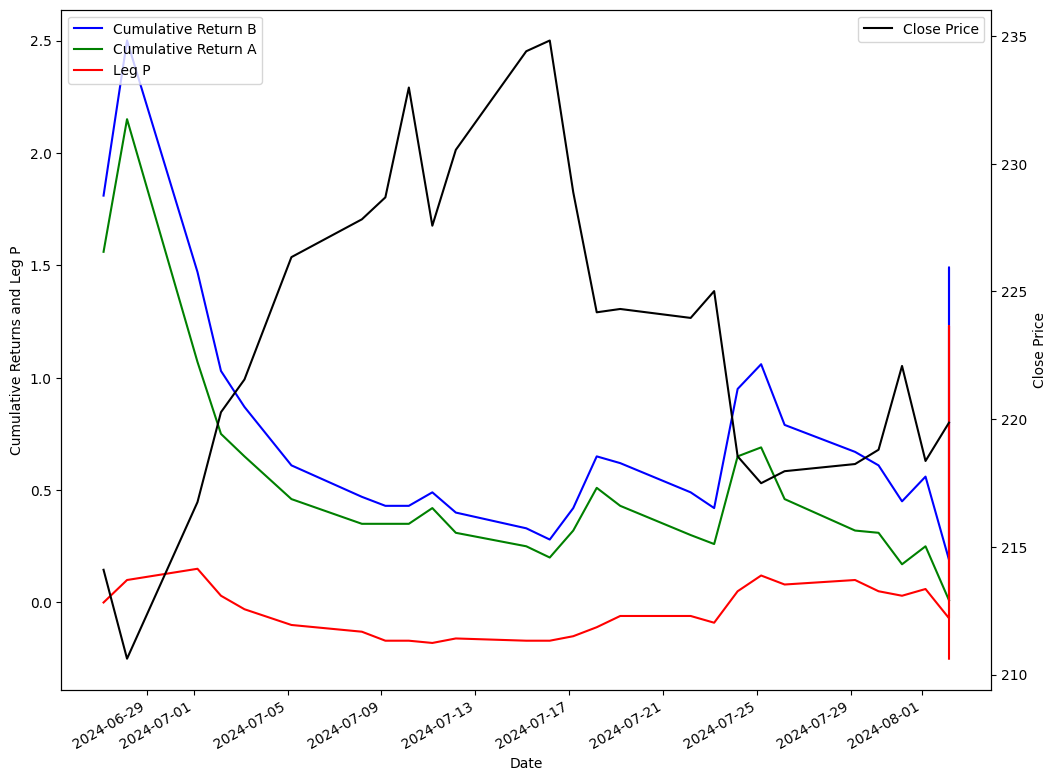

In [19]:
import matplotlib.pyplot as plt

# Assuming df is already defined and contains the relevant columns

# Create a plot with two y-axes, setting the figure size to 12x10 inches
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot cum_return_B, cum_return_A, and leg_P on the left y-axis (ax1)
ax1.plot(df_option['fecha'], df_option['close_A'], label='Cumulative Return B', color='blue')
ax1.plot(df_option['fecha'], df_option['close_B'], label='Cumulative Return A', color='green')
ax1.plot(df_option['fecha'], df_option['leg_P'], label='Leg P', color='red')

# Plot close_price on the right y-axis (ax2)
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
ax2.plot(df_option['fecha'], df_option['close_price'], label='Close Price', color='black')

# Set labels
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns and Leg P')
ax2.set_ylabel('Close Price', color='black')

# Set the color of the ticks and label for the right y-axis to black
ax2.tick_params(axis='y', labelcolor='black')

# Add legends to both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Optionally, format the date on the x-axis
fig.autofmt_xdate()

# Show plot
plt.show()

In [15]:
df_option

,timestamp,close_A,close_B,close_price,fecha,cum_return_B,cum_return_A,leg_P
0,1719460800000,1.81,1.56,214.10,2024-06-27 04:00:00,0.00,0.00,0.00
1,1719547200000,2.50,2.15,210.62,2024-06-28 04:00:00,-0.59,0.69,0.10
2,1719806400000,1.47,1.07,216.75,2024-07-01 04:00:00,0.49,-0.34,0.15
3,1719892800000,1.03,0.75,220.27,2024-07-02 04:00:00,0.81,-0.78,0.03
4,1719979200000,0.87,0.65,221.55,2024-07-03 04:00:00,0.91,-0.94,-0.03
5,1720152000000,0.61,0.46,226.34,2024-07-05 04:00:00,1.10,-1.20,-0.10
6,1720411200000,0.47,0.35,227.82,2024-07-08 04:00:00,1.21,-1.34,-0.13
7,1720497600000,0.43,0.35,228.68,2024-07-09 04:00:00,1.21,-1.38,-0.17
8,1720584000000,0.43,0.35,232.98,2024-07-10 04:00:00,1.21,-1.38,-0.17
9,1720670400000,0.49,0.42,227.57,2024-07-11 04:00:00,1.14,-1.32,-0.18


In [16]:
print(df.columns)

Index(['timestamp', 'close_price', 'fecha'], dtype='object')


In [17]:
df = get_stock_data_for_date(date, DTE_A)
expiration_day_A = next_working_day(date, DTE_A)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_A = pd.to_datetime(expiration_day_A).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_A = current_stock_price + distance_A
option_ticker_A = generate_option_ticker(expiration_day_A, option_type_A, strike_A)
print (option_ticker_A)
df_option_A = get_option_price(option_ticker_A, date, expiration_day_A, option_type_A)
df_option_A.rename(columns={'option_code': 'option_code_A', 'close': 'close_A', 'option_type': 'option_type_A'}, inplace=True)

NameError: name 'DTE_A' is not defined

In [ ]:
def generate_option_ticker(expiration_day_B, option_type_B, strike_B):
    # Convert expiration_day_B to the desired format (YYMMDD without '20' and '-')
    expiration_day_B_formatted = expiration_day_B.strftime('%y%m%d')
    strike_B_formatted = f'{strike_B:05d}'
    option_ticker_B = f'O:SPY{expiration_day_B_formatted}{option_type_B}{strike_B_formatted}000'
    return option_ticker_B

In [ ]:
def plot_option_chart(df_option, strike_B, option_type_B, option_ticker_B, fila, option_type_A, strike_A, option_type_C, strike_C, option_type_D, strike_D):
    ovenight_index = int(len(df_option) / 2) - 40
    end_index = len(df_option) - 2

    df_option['fecha'] = df_option['fecha'].astype(str)
    fig, (ax1, ax3) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.04})
    ax2 = ax1.twinx()
    ax2.plot(df_option['fecha'], df_option['stock_price'], color='blue', alpha=1.0, linewidth=1.4)
    ax1.plot(df_option['fecha'], df_option['close_D'], color='firebrick', label='D', linewidth=1.0)
    ax1.plot(df_option['fecha'], df_option['close_C'], color='red', label='C', linewidth=1.0)
    ax1.plot(df_option['fecha'], df_option['close_B'], color='green', label='B', linewidth=1.0)
    ax1.plot(df_option['fecha'], df_option['close_A'], color='olive', label='A', linewidth=1.0)
    
    ax1.fill_between(df_option['fecha'], df_option['close_B'], df_option['close_A'], color='lightgreen', alpha=0.5)
    ax1.fill_between(df_option['fecha'], df_option['close_C'], df_option['close_D'], color='lightcoral', alpha=0.5)
    
    ax2.plot(df_option['fecha'], df_option['stock_price'], color='blue', alpha=1.0, linewidth=0.8)
    ax1.set_ylabel('Prima', color='green')
    ax2.set_ylabel('Stock Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='green')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax1.yaxis.grid(True, alpha=0.6)
    ax1.xaxis.grid(False)
    
    ax1.tick_params(axis='x', which='both', length=0, labelbottom=False)
    
    ax1.axvline(x=fila, color='grey', alpha=0.56, linestyle='-', linewidth=0.7)
    ax1.axvline(x=ovenight_index, color='grey', alpha=0.5, linestyle='-', linewidth=0.7)
    
    ax2.axhline(y=strike_B, color='green', alpha=0.7, linestyle='--')
    ax2.axhline(y=strike_A, color='olive', alpha=0.7, linestyle='--')
    ax2.axhline(y=strike_C, color='red', alpha=0.7, linestyle='--')
    ax2.axhline(y=strike_D, color='firebrick', alpha=0.7, linestyle='--')
    
    
    ax2.plot(df_option['fecha'][fila], df_option['stock_price'][fila], 'ko', markersize=9)
    
    ax2.plot(df_option['fecha'][ovenight_index], df_option['stock_price'][ovenight_index], 'ro', markersize=9)
    ax2.plot(df_option['fecha'][end_index], df_option['stock_price'][end_index], 'ro', markersize=9)
    
    ax1.set_title(f'Main: {option_ticker_B} - (A){option_type_A}{strike_A}  (B){option_type_B}{strike_B} / (C){option_type_C}{strike_C}  (D){option_type_D}{strike_D}  ')
    
    ax3.fill_between(df_option['fecha'], df_option['cum_return'], where=(df_option['cum_return'] >= 0),
                     color='green', alpha=0.5, label=' ')
    ax3.fill_between(df_option['fecha'], df_option['cum_return'], where=(df_option['cum_return'] < 0),
                     color='red', alpha=0.5, label=' ')
    ax3.set_ylabel('Beneficio Acumulado')
    ax3.tick_params(axis='y')
    ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
    
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment('right')

    ax3.yaxis.grid(True, alpha=0.6)
    ax3.xaxis.grid(False)
    ax1.legend(loc='upper center')

    output_dir = 'chart_oputput_sim'
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'sell_the_swan_{timestamp}.png'
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path)
    plt.show()

In [ ]:
df

DISEÑO

In [ ]:
date = '2024-08-06'

# OPTION A
option_type_A = 'P'
distance_A =    -3
DTE_A =          1

# OPTION B
option_type_B = 'P'
distance_B =    -1
DTE_B =          1

# OPTION C
option_type_C = 'C'
distance_C =     1
DTE_C =          1

# OPTION D
option_type_D = 'C'
distance_D =     3
DTE_D =          1

In [ ]:
# OPTION A - elegir vencimiento
df = get_stock_data_for_date(date, DTE_A)
expiration_day_A = next_working_day(date, DTE_A)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_A = pd.to_datetime(expiration_day_A).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_A = current_stock_price + distance_A
option_ticker_A = generate_option_ticker(expiration_day_A, option_type_A, strike_A)
print (option_ticker_A)
df_option_A = get_option_price(option_ticker_A, date, expiration_day_A, option_type_A)
df_option_A.rename(columns={'option_code': 'option_code_A', 'close': 'close_A', 'option_type': 'option_type_A'}, inplace=True)

In [ ]:
# OPTION B - elegir vencimiento
df = get_stock_data_for_date(date, DTE_B)
expiration_day_B = next_working_day(date, DTE_B)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_B = pd.to_datetime(expiration_day_B).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_B = current_stock_price + distance_B
option_ticker_B = generate_option_ticker(expiration_day_B, option_type_B, strike_B)
print (option_ticker_B)
df_option_B = get_option_price(option_ticker_B, date, expiration_day_B, option_type_B)
df_option_B.rename(columns={'option_code': 'option_code_B', 'close': 'close_B', 'option_type': 'option_type_B'}, inplace=True)

In [ ]:
# OPTION C - elegir vencimiento
df = get_stock_data_for_date(date, DTE_C)
expiration_day_C = next_working_day(date, DTE_C)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_C = pd.to_datetime(expiration_day_C).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_C = current_stock_price + distance_C
option_ticker_C = generate_option_ticker(expiration_day_C, option_type_C, strike_C)
print (option_ticker_C)
df_option_C = get_option_price(option_ticker_C, date, expiration_day_C, option_type_C)
df_option_C.rename(columns={'option_code': 'option_code_C', 'close': 'close_C', 'option_type': 'option_type_C'}, inplace=True)

In [ ]:
# OPTION D - elegir vencimiento
df = get_stock_data_for_date(date, DTE_D)
expiration_day_D = next_working_day(date, DTE_D)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_D = pd.to_datetime(expiration_day_D).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_D = current_stock_price + distance_D
option_ticker_D = generate_option_ticker(expiration_day_D, option_type_D, strike_D)
print (option_ticker_D)
df_option_D = get_option_price(option_ticker_D, date, expiration_day_D, option_type_D)
df_option_D.rename(columns={'option_code': 'option_code_D', 'close': 'close_D', 'option_type': 'option_type_D'}, inplace=True)

In [ ]:
print('\nOPCION A')
print(f'Fecha entrada      {date}')
print(f'Fecha vencimiento  {expiration_day_A}')
print(f'Precio Subyacente         {current_stock_price}')
print(f'Precio Strike {option_type_A} {distance_A}        {strike_A}')
print(f'DTE                         {DTE_A}\n')
print('OPCION B')
print(f'Fecha entrada      {date}')
print(f'Fecha vencimiento  {expiration_day_B}')
print(f'Precio Subyacente         {current_stock_price}')
print(f'Precio Strike {option_type_B} {distance_B}        {strike_B}')
print(f'DTE                         {DTE_B}\n')
print('OPCION C')
print(f'Fecha entrada      {date}')
print(f'Fecha vencimiento  {expiration_day_C}')
print(f'Precio Subyacente         {current_stock_price}')
print(f'Precio Strike {option_type_C} {distance_C}         {strike_C}')
print(f'DTE                         {DTE_C}\n')
print('OPCION D')
print(f'Fecha entrada      {date}')
print(f'Fecha vencimiento  {expiration_day_D}')
print(f'Precio Subyacente         {current_stock_price}')
print(f'Precio Strike {option_type_D} {distance_D}         {strike_D}')
print(f'DTE                         {DTE_D}\n')

MERGE, PROFIT AND PLOT

In [ ]:
df_option = pd.merge(df_option_B, df, on='timestamp', how='left')
df_option = pd.merge(df_option, df_option_A,  on='timestamp', how='left')
df_option = pd.merge(df_option, df_option_C,  on='timestamp', how='left')
df_option = pd.merge(df_option, df_option_D,  on='timestamp', how='left')

In [ ]:
coste_B = df_option['close_B'].iloc[0]
df_option['cum_return_B'] = coste_B - df_option['close_B']

coste_A = df_option['close_A'].iloc[0]
df_option['cum_return_A'] = df_option['close_A'] - coste_A 

coste_C = df_option['close_C'].iloc[0]
df_option['cum_return_C'] = coste_C - df_option['close_C']

df_option['cum_return'] = df_option['cum_return_B'] + df_option['cum_return_A'] + df_option['cum_return_C']
df_option = df_option.fillna(method='ffill')

In [ ]:
plot_option_chart(df_option, strike_B, option_type_B, option_ticker_B, fila, option_type_A, strike_A, option_type_C, strike_C, option_type_D, strike_D)

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'options_sim_{timestamp}.csv'
df_option.to_csv(filename, index=False)

In [ ]:
df_option